**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
!pip install pycodestyle flake8 pycodestyle_magic

In [59]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree, DistanceMetric, NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from scipy.spatial.distance import cdist


%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [41]:
#%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        if self.algorithm == 'kd_tree':
            arr = np.array(X)
            self.train_y = np.array(y)
            self.tree = KDTree(arr, metric=self.metric)
        elif self.algorithm == 'brute':
            self.train_x = np.array(X)
            self.train_y = np.array(y)
            self.neigh = NearestNeighbors(self.n_neighbors, metric=self.metric)
            self.neigh.fit(X)
        self.number_of_classes = len(np.unique(self.train_y))

    def predict_brute(self, X):
        test_labels = []
        ind = self.neigh.kneighbors(X, return_distance=False)
        for y in self.train_y[ind]:
            test_labels = np.append(test_labels, np.bincount(y).argmax())
        return test_labels.astype(int)

    def predict_proba_brute(self, X):
        test_labels = np.array([])
        dist, ind = self.neigh.kneighbors(X)
        for y in self.train_y[ind]:
            stat = np.array([])
            for i in range(self.number_of_classes):
                stat = np.append(stat, np.count_nonzero(y == i))
            test_labels = np.append(test_labels, stat)
        test_labels.shape = (X.shape[0], self.number_of_classes)
        test_labels = np.divide(test_labels, self.n_neighbors)
        return test_labels

    def predict_kd_tree(self, X):
        test_labels = np.array([])
        dist, ind = self.tree.query(X, k=self.n_neighbors)
        for y in self.train_y[ind]:
            test_labels = np.append(test_labels, np.bincount(y).argmax())
        return test_labels.astype(int)

    def predict_proba_kd_tree(self, X):
        test_labels = np.array([])
        dist, ind = self.tree.query(X, k=self.n_neighbors)
        for y in self.train_y[ind]:
            stat = np.array([])
            for i in range(self.number_of_classes):
                stat = np.append(stat, np.count_nonzero(y == i))
            test_labels = np.append(test_labels, stat)
        test_labels.shape = (X.shape[0], self.number_of_classes)
        test_labels = np.divide(test_labels, self.n_neighbors)
        return test_labels

    def predict(self, X):
        if self.algorithm == 'brute':
            return np.array(self.predict_brute(X))
        elif self.algorithm == 'kd_tree':
            return np.array(self.predict_kd_tree(X))

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            return self.predict_proba_brute(X)
        elif self.algorithm == 'kd_tree':
            return self.predict_proba_kd_tree(X, )

    def score(self, X, y):
        vector = np.subtract(self.predict(X), y)
        summa = np.count_nonzero(vector)
        return 1 - summa/y.shape[0]

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [21]:
iris = datasets.load_iris()

In [22]:
X_train, X_test, y_train, y_test = list(map(np.array, train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)))

In [23]:
clf = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=3, algorithm='brute')

In [24]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [25]:
my_clf.score(X_test, y_test)

0.9333333333333333

In [26]:
clf.score(X_test,y_test)

0.9333333333333333

In [27]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [61]:
%timeit clf.fit(X_train, y_train)

197 µs ± 8.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
%timeit my_clf.fit(X_train, y_train)

75.3 µs ± 4.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
%timeit clf.predict(X_test)

1.01 ms ± 87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [64]:
%timeit my_clf.predict(X_test)

576 µs ± 39.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [65]:
%timeit clf.predict_proba(X_test)

573 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [66]:
%timeit my_clf.predict_proba(X_test)

1.33 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [74]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [75]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [76]:
%timeit clf.fit(X_train, y_train)

360 µs ± 57.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [77]:
%timeit my_clf.fit(X_train, y_train)

73.9 µs ± 4.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [78]:
%timeit clf.predict(X_test)
clf.predict(X_test)

1.11 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([1, 2, 2, 1, 0, 0, 2, 2, 0, 1, 1, 1, 0, 2, 0])

In [79]:
%timeit my_clf.predict(X_test)
my_clf.predict(X_test)

219 µs ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([1, 2, 2, 1, 0, 0, 2, 2, 0, 1, 1, 1, 0, 2, 0])

In [80]:
%timeit clf.predict_proba(X_test)
clf.predict_proba(X_test)

463 µs ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [81]:
%timeit my_clf.predict_proba(X_test)
my_clf.predict_proba(X_test)

561 µs ± 81.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [82]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

#### Посмотрим время предикта my_clf на синтетическом большом датасете

In [106]:
from sklearn.datasets import make_classification

## BRUTE
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

X,y = make_classification(n_samples=10000, n_features=10, n_informative=8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [107]:
%timeit clf.fit(X_train, y_train)

590 µs ± 60.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [108]:
%timeit my_clf.fit(X_train, y_train)

2.96 ms ± 62.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [86]:
%timeit clf.predict(X_test)

212 ms ± 5.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
%timeit my_clf.predict(X_test)

82.4 ms ± 9.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [88]:
%timeit clf.predict_proba(X_test)

176 ms ± 6.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
%timeit my_clf.predict_proba(X_test)

118 ms ± 2.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
print (clf.score(X_test,y_test), my_clf.score(X_test, y_test))

0.9545 0.9545


In [90]:
## KD-Tree
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

X,y = make_classification(n_samples=10000, n_features=10, n_informative=8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [91]:
%timeit clf.fit(X_train, y_train)

3.79 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [92]:
%timeit my_clf.fit(X_train, y_train)

3.06 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
%timeit clf.predict(X_test)

125 ms ± 5.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
%timeit my_clf.predict(X_test)

87.1 ms ± 6.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
%timeit clf.predict_proba(X_test)

73.5 ms ± 6.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
%timeit my_clf.predict_proba(X_test)

116 ms ± 9.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
print (clf.score(X_test,y_test), my_clf.score(X_test, y_test))

0.9425 0.9425


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [42]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [43]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [44]:
import string
import re
data = list(map(lambda x: x.lower(), data))

reg = re.compile('[^a-z ]')
for i, text in enumerate(data):
    text = text.replace('\n', ' ').replace('\t', ' ')
    data[i] = reg.sub('', text)
    

In [45]:
data[1]

'a fair number of brave souls who upgraded their si clock oscillator have shared their experiences for this poll please send a brief message detailing your experiences with the procedure top speed attained cpu rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with  and  m floppies are especially requested  i will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and havent answered this poll thanks'

In [46]:
## ЛЕММАТИЗАЦИЯ

import nltk
from nltk.stem import WordNetLemmatizer 

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/pus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
lemm_data_tok = [[lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)] for text in data]

In [48]:
Empty_Texts = list(map(lambda tok: all(list(map(lambda x: x=='', tok))), lemm_data_tok))
Indicies = np.where(True ==  np.asarray(Empty_Texts))[0]
for i in Indicies[::-1]:
    lemm_data_tok.pop(i)

In [49]:
assert all(isinstance(row, (list, tuple)) for row in lemm_data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in lemm_data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, lemm_data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [50]:
from scipy.sparse import csr_matrix
data = []
indptr = [0]
indices = []
vocabulary = {}

for d in lemm_data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))


Toks_CSR_Matrix = csr_matrix((data, indices, indptr), dtype=int).toarray()

In [51]:
Toks_CSR_Matrix.shape

(11004, 85638)

In [52]:
Cleared_Target = np.delete(target, Indicies)

In [53]:
Cleared_Target.shape

(11004,)

#### Избавимся от слов (колонок в матрице) которые встретились во всех текстах менее 2 раз и более 10'000 раз

In [54]:
Freqs = Toks_CSR_Matrix.sum(axis=0)
Index_to_Clear = np.where((Freqs>=2) & (Freqs<=10000))[0]

In [55]:
Toks_CSR_Matrix = Toks_CSR_Matrix[:,Index_to_Clear]

In [56]:
Toks_CSR_Matrix.shape

(11004, 33922)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [37]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [38]:
Train_X, Test_X, Train_y, Test_y = train_test_split(Toks_CSR_Matrix, Cleared_Target, test_size=0.1, random_state=42)

In [39]:
%time clf.fit(Train_X, Train_y)

CPU times: user 3.2 ms, sys: 18.2 ms, total: 21.4 ms
Wall time: 43 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [40]:
%time my_clf.fit(Train_X, Train_y)

CPU times: user 23.5 s, sys: 5.68 s, total: 29.1 s
Wall time: 31.8 s


In [41]:
%time clf.score(Test_X, Test_y)

CPU times: user 22.8 s, sys: 5.15 s, total: 27.9 s
Wall time: 19.7 s


0.22343324250681199

In [42]:
%time my_clf.score(Test_X, Test_y)

CPU times: user 9min 56s, sys: 6.2 s, total: 10min 2s
Wall time: 10min 12s


0.23069936421435056

## CV поиск KN : Sparse

In [60]:
CV_Scores = []
kn_count=0
for kn in range(2,7):
    cv_count=0
    my_clf = MyKNeighborsClassifier(n_neighbors=kn, algorithm='brute')
    scores=[]
    skf = StratifiedKFold(3, True, 42)
    for train_index, test_index in skf.split(Toks_CSR_Matrix, Cleared_Target):
        cv_count+=1
        Train_X, Test_X = Toks_CSR_Matrix[train_index,:], Toks_CSR_Matrix[test_index,:]
        Train_y, Test_y = Cleared_Target[train_index], Cleared_Target[test_index]
        my_clf.fit(Train_X, Train_y)
        scores.append(my_clf.score(Test_X, Test_y))
        print(cv_count)
    kn_count+=1
    CV_Scores.append((kn, scores))
    print(kn_count)

1
2
3
1
1
2
3
2
1
2
3
3
1
2
3
4
1
2
3
5


In [61]:
for score in CV_Scores:
    print('For K Neighbors= {} : score= {}, mean score= {}'.format(score[0], np.round(score[1], 4), np.round(np.mean(score[1]), 4) ))

For K Neighbors= 2 : score= [0.232  0.2146 0.2233], mean score= 0.2233
For K Neighbors= 3 : score= [0.2295 0.2151 0.2129], mean score= 0.2192
For K Neighbors= 4 : score= [0.2317 0.2197 0.2156], mean score= 0.2224
For K Neighbors= 5 : score= [0.232  0.2315 0.229 ], mean score= 0.2308
For K Neighbors= 6 : score= [0.2363 0.2328 0.229 ], mean score= 0.2327


In [62]:
To_plot = list(zip(*CV_Scores))

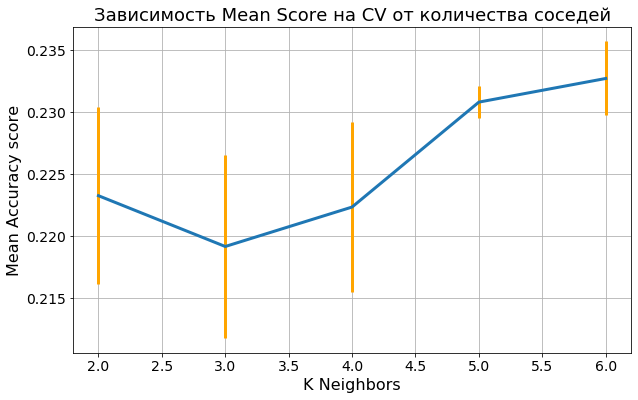

In [63]:
plt.figure(figsize=(10,6))
plt.title(u'Зависимость Mean Score на CV от количества соседей', fontsize=18)
plt.xlabel('K Neighbors', fontsize=16)
plt.ylabel('Mean Accuracy score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.errorbar(x=To_plot[0], y=np.mean(list(To_plot[1]), axis=1),
             yerr=np.std(list(To_plot[1]), axis=1), ecolor='orange', linewidth=3)
plt.grid()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [57]:
from sklearn.feature_extraction.text import TfidfTransformer
TfIdf_Matrix = TfidfTransformer().fit_transform(Toks_CSR_Matrix).toarray()

## CV поиск KN : Tf-Idf

In [42]:
CV_Scores = []
for kn in range(2,10):
    my_clf = MyKNeighborsClassifier(n_neighbors=kn, algorithm='brute', metric='cosine')
    scores=[]
    skf = StratifiedKFold(3, True, 42)
    for train_index, test_index in skf.split(TfIdf_Matrix, Cleared_Target):
        Train_X, Test_X = TfIdf_Matrix[train_index,:], TfIdf_Matrix[test_index,:]
        Train_y, Test_y = Cleared_Target[train_index], Cleared_Target[test_index]
        my_clf.fit(Train_X, Train_y)
        scores.append(my_clf.score(Test_X, Test_y))
    CV_Scores.append((kn, scores))

In [43]:
for score in CV_Scores:
    print('For K Neighbors= {} : score= {}, mean score= {}'.format(score[0], np.round(score[1], 4), np.round(np.mean(score[1]), 4) ))

For K Neighbors= 2 : score= [0.6032 0.6011 0.6018], mean score= 0.6021
For K Neighbors= 3 : score= [0.6271 0.6298 0.6226], mean score= 0.6265
For K Neighbors= 4 : score= [0.6394 0.6388 0.6335], mean score= 0.6372
For K Neighbors= 5 : score= [0.6511 0.6489 0.6382], mean score= 0.646
For K Neighbors= 6 : score= [0.6513 0.6549 0.6398], mean score= 0.6487
For K Neighbors= 7 : score= [0.6538 0.6538 0.6436], mean score= 0.6504
For K Neighbors= 8 : score= [0.6622 0.6519 0.6453], mean score= 0.6531
For K Neighbors= 9 : score= [0.6617 0.6559 0.6521], mean score= 0.6566


In [56]:
To_plot = list(zip(*CV_Scores))

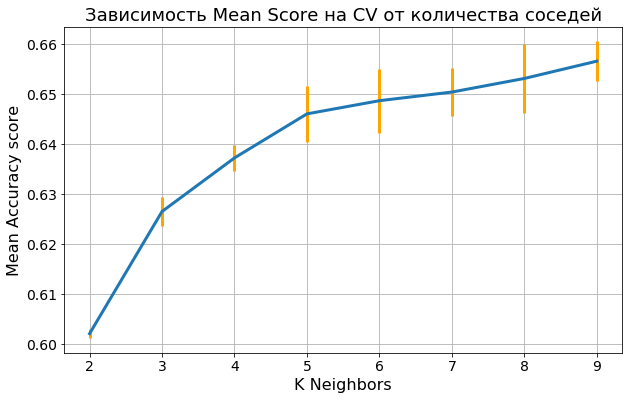

In [88]:
plt.figure(figsize=(10,6))
plt.title(u'Зависимость Mean Score на CV от количества соседей', fontsize=18)
plt.xlabel('K Neighbors', fontsize=16)
plt.ylabel('Mean Accuracy score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.errorbar(x=To_plot[0], y=np.mean(list(To_plot[1]), axis=1),
             yerr=np.std(list(To_plot[1]), axis=1), ecolor='orange', linewidth=3)
plt.grid()

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [21]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [22]:
data_test = newsgroups_test.data
target_test = newsgroups_test.target

In [23]:
import string
import re
data_test = list(map(lambda x: x.lower(), data_test))

reg = re.compile('[^a-z ]')
for i, text in enumerate(data_test):
    text = text.replace('\n', ' ').replace('\t', ' ')
    data_test[i] = reg.sub('', text)

In [24]:
# Также лемматизируем слова из тестовой выборки
lemmatizer = WordNetLemmatizer()

sentence = data_test[1]
word_list = nltk.word_tokenize(sentence)
print(word_list)

lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
print(lemmatized_output)

['im', 'not', 'familiar', 'at', 'all', 'with', 'the', 'format', 'of', 'these', 'xface', 'thingies', 'but', 'after', 'seeing', 'them', 'in', 'some', 'folks', 'headers', 'ive', 'got', 'to', 'see', 'them', 'and', 'maybe', 'make', 'one', 'of', 'my', 'own', 'ive', 'got', 'dpgview', 'on', 'my', 'linux', 'box', 'which', 'displays', 'uncompressed', 'xfaces', 'and', 'ive', 'managed', 'to', 'compile', 'uncompface', 'too', 'but', 'now', 'that', 'im', 'looking', 'for', 'them', 'i', 'cant', 'seem', 'to', 'find', 'any', 'xfaces', 'in', 'anyones', 'news', 'headers', 'could', 'you', 'would', 'you', 'please', 'send', 'me', 'your', 'xface', 'header', 'i', 'know', 'ill', 'probably', 'get', 'a', 'little', 'swamped', 'but', 'i', 'can', 'handle', 'it', 'i', 'hope']
im not familiar at all with the format of these xface thingies but after seeing them in some folk header ive got to see them and maybe make one of my own ive got dpgview on my linux box which display uncompressed xfaces and ive managed to compile

In [25]:
lemm_data_test_tok = [[lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)] for text in data_test]

In [26]:
# Удалим пустые тексты
Empty_Texts = list(map(lambda tok: all(list(map(lambda x: x=='', tok))), lemm_data_test_tok))
Indicies_test = np.where(True ==  np.asarray(Empty_Texts))[0]
for i in Indicies_test[::-1]:
    lemm_data_test_tok.pop(i)

In [27]:
assert all(isinstance(row, (list, tuple)) for row in lemm_data_test_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in lemm_data_test_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, lemm_data_test_tok))), "please make sure that you lowercase the data and drop spaced texts"

In [28]:
len(vocabulary)

85638

In [29]:
# Построим спарс матрицу тестовой выборки на основе словаря обучающей выборки
from scipy.sparse import csr_matrix
test_data = []
test_indptr = [0]
test_indices = []
test_vocabulary = {}

for d in lemm_data_test_tok:
    for term in d:
        # vocalubary -- словарь из обучения
        index = vocabulary.setdefault(term, len(test_vocabulary))
        test_indices.append(index)
        test_data.append(1)
    test_indptr.append(len(test_indices))


Test_Toks_CSR_Matrix = csr_matrix((test_data, test_indices, test_indptr), dtype=int).toarray()

In [30]:
Test_Toks_CSR_Matrix.shape

(7307, 85638)

In [31]:
target_test.shape

(7532,)

In [32]:
Cleared_Target_Test = np.delete(target_test, Indicies_test)

In [33]:
Cleared_Target_Test.shape

(7307,)

In [34]:
## Удалим некоторые слова из матрицы по тем же индексам 
## которые были получены из обучающей выборки

Test_Toks_CSR_Matrix = Test_Toks_CSR_Matrix[:,Index_to_Clear]
TfIdf_Test_Matrix = TfidfTransformer().fit_transform(Test_Toks_CSR_Matrix).toarray()

## Обучение

In [89]:
print(TfIdf_Matrix.shape)
print(Cleared_Target.shape)

(11004, 33922)
(11004,)


In [91]:
my_clf = MyKNeighborsClassifier(n_neighbors=7, algorithm='brute', metric='cosine')

Train_X, Test_X, Train_y, Test_y = train_test_split(TfIdf_Matrix, Cleared_Target,
                                                    test_size=0.1, random_state=42, stratify=Cleared_Target)
my_clf.fit(Train_X, Train_y)

print(my_clf.score(Test_X, Test_y))

0.6530426884650318


In [92]:
clf = KNeighborsClassifier(n_neighbors=7, algorithm='brute', metric='cosine')

Train_X, Test_X, Train_y, Test_y = train_test_split(TfIdf_Matrix, Cleared_Target,
                                                    test_size=0.1, random_state=42, stratify=Cleared_Target)
clf.fit(Train_X, Train_y)

print(clf.score(Test_X, Test_y))

0.6530426884650318


## Тест

In [93]:
print(TfIdf_Test_Matrix.shape)
print(Cleared_Target_Test.shape)

(7307, 33922)
(7307,)


In [94]:
my_clf.score(TfIdf_Test_Matrix, Cleared_Target_Test)

0.576159846722321

In [95]:
clf.score(TfIdf_Test_Matrix, Cleared_Target_Test)

0.576159846722321